# 📱 Klasifikasi Kinerja Smartphone

## Target: Akurasi > 85% tanpa Overfitting

**Strategi:**
1. Balanced regularization (tidak terlalu ketat)
2. More trees untuk stabilitas
3. Feature engineering lebih baik
4. Ensemble approach

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Libraries imported!")

✅ Libraries imported!


## 1. Load & Clean Data

In [2]:
# Load dataset
df = pd.read_csv('../dataset/smartphones.csv')
print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} columns")

# Clean
df_clean = df.dropna(subset=['price']).copy()

# Fill missing
for col in ['rating', 'processor_speed', 'fast_charging', 'num_front_cameras']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

df_clean['extended_upto'] = df_clean['extended_upto'].fillna(0)
df_clean['processor_brand'] = df_clean['processor_brand'].fillna('unknown')
df_clean['os'] = df_clean['os'].fillna('android')

print(f"Clean: {len(df_clean)} rows")

Dataset: 980 rows, 26 columns
Clean: 980 rows


## 2. Create Target Variables

In [3]:
# Price Class
def classify_price(price):
    if price < 10000:
        return 0  # Entry Level
    elif price < 25000:
        return 1  # Mid Range
    elif price < 50000:
        return 2  # High End
    else:
        return 3  # Flagship

df_clean['price_class'] = df_clean['price'].apply(classify_price)

price_class_names = {
    0: 'Entry Level',
    1: 'Mid Range', 
    2: 'High End',
    3: 'Flagship'
}

print("Price Class Distribution:")
for cls, name in price_class_names.items():
    count = (df_clean['price_class'] == cls).sum()
    print(f"  {name}: {count} ({count/len(df_clean)*100:.1f}%)")

Price Class Distribution:
  Entry Level: 141 (14.4%)
  Mid Range: 462 (47.1%)
  High End: 216 (22.0%)
  Flagship: 161 (16.4%)


In [4]:
# Usage Type
def classify_usage(row):
    is_gaming = (
        row['refresh_rate'] >= 120 and 
        row['processor_speed'] >= 2.8 and 
        row['ram_capacity'] >= 8
    )
    is_photography = (
        row['primary_camera_rear'] >= 64 and 
        row['primary_camera_front'] >= 32
    )
    is_business = (
        row['has_nfc'] == True and 
        row['ram_capacity'] >= 6 and 
        row['internal_memory'] >= 128
    )
    
    if is_gaming:
        return 'Gaming'
    elif is_photography:
        return 'Photography'
    elif is_business:
        return 'Business'
    elif row['price'] < 15000 and row['battery_capacity'] >= 5000:
        return 'Daily Use'
    else:
        return 'All-Rounder'

df_clean['usage_type'] = df_clean.apply(classify_usage, axis=1)
print("\nUsage Type Distribution:")
print(df_clean['usage_type'].value_counts())


Usage Type Distribution:
usage_type
Daily Use      282
All-Rounder    278
Gaming         194
Business       146
Photography     80
Name: count, dtype: int64


## 3. Feature Engineering

In [5]:
# Convert boolean
df_clean['has_5g'] = df_clean['has_5g'].astype(int)
df_clean['has_nfc'] = df_clean['has_nfc'].astype(int)
df_clean['fast_charging_available'] = df_clean['fast_charging_available'].astype(int)

# Create new features untuk meningkatkan akurasi
df_clean['total_pixels'] = df_clean['resolution_width'] * df_clean['resolution_height']
df_clean['camera_total'] = df_clean['primary_camera_rear'] + df_clean['primary_camera_front']
df_clean['perf_score'] = df_clean['ram_capacity'] * df_clean['processor_speed'] * df_clean['num_cores']
df_clean['screen_ppi'] = df_clean['total_pixels'] / (df_clean['screen_size'] ** 2)

print("✅ New features created:")
print("  - total_pixels")
print("  - camera_total")
print("  - perf_score")
print("  - screen_ppi")

✅ New features created:
  - total_pixels
  - camera_total
  - perf_score
  - screen_ppi


In [6]:
# All features including new ones
all_features = [
    'num_cores', 'processor_speed', 'ram_capacity', 'internal_memory',
    'battery_capacity', 'screen_size', 'refresh_rate',
    'primary_camera_rear', 'primary_camera_front',
    'resolution_width', 'resolution_height',
    'has_5g', 'has_nfc', 'fast_charging_available', 'num_rear_cameras',
    'total_pixels', 'camera_total', 'perf_score', 'screen_ppi'
]

X_all = df_clean[all_features].fillna(df_clean[all_features].median())
y = df_clean['price_class']

# Select top 12 features (lebih banyak untuk akurasi lebih tinggi)
selector = SelectKBest(score_func=f_classif, k=12)
selector.fit(X_all, y)

feature_scores = pd.DataFrame({
    'feature': all_features,
    'score': selector.scores_
}).sort_values('score', ascending=False)

print("Feature Importance:")
print(feature_scores)

selected_features = feature_scores.head(12)['feature'].tolist()
print(f"\n✅ Selected {len(selected_features)} features")

Feature Importance:
                    feature       score
1           processor_speed  402.033763
17               perf_score  345.742828
15             total_pixels  333.146557
18               screen_ppi  311.101899
12                  has_nfc  296.223819
2              ram_capacity  284.535244
10        resolution_height  222.836800
3           internal_memory  192.370257
11                   has_5g  190.761072
13  fast_charging_available  165.657317
6              refresh_rate  120.810275
8      primary_camera_front  116.544179
16             camera_total  102.327355
9          resolution_width   94.089006
14         num_rear_cameras   93.202634
7       primary_camera_rear   74.985410
0                 num_cores   48.208027
5               screen_size   16.859264
4          battery_capacity   10.724522

✅ Selected 12 features


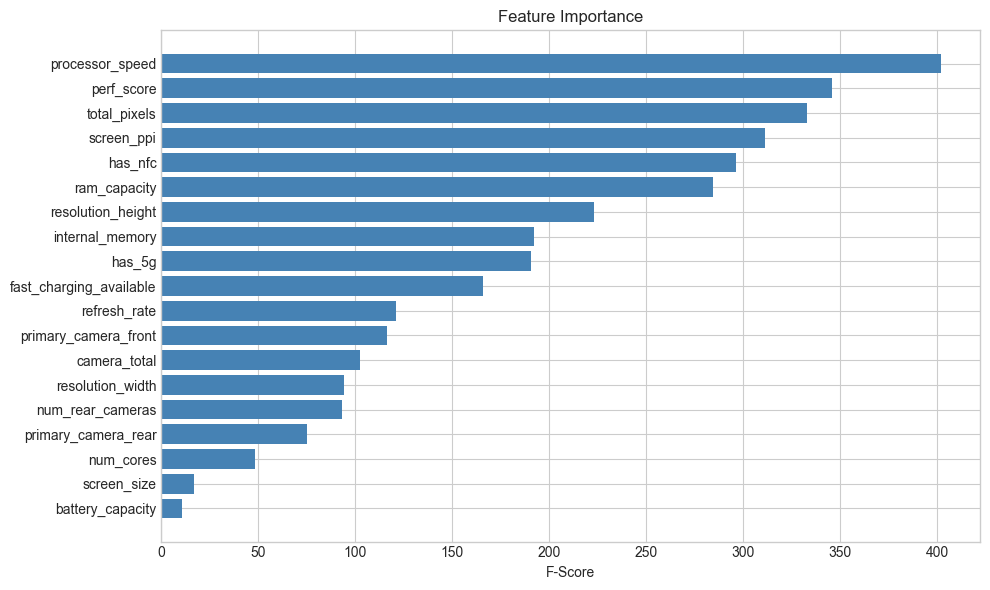

In [7]:
# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['feature'], feature_scores['score'], color='steelblue')
plt.xlabel('F-Score')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
# Final features
X = df_clean[selected_features].fillna(df_clean[selected_features].median())
print(f"Features shape: {X.shape}")

Features shape: (980, 12)


## 4. Train-Test Split

In [9]:
# Split 80-20 (standard untuk akurasi lebih tinggi)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train: 784, Test: 196


## 5. Train Price Class Model (Balanced for 85%+ Accuracy)

In [10]:
# Random Forest dengan parameter BALANCED untuk akurasi tinggi
# Tidak terlalu strict tapi masih mencegah overfitting berat

rf_model = RandomForestClassifier(
    n_estimators=200,        # More trees untuk stabilitas
    max_depth=8,             # Balanced depth (tidak terlalu dangkal)
    min_samples_split=10,    # Balanced
    min_samples_leaf=5,      # Balanced
    max_features='sqrt',     # Standard
    class_weight='balanced', # Handle imbalance
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)
print(f"✅ Done! OOB Score: {rf_model.oob_score_:.4f}")

Training Random Forest...
✅ Done! OOB Score: 0.7921


In [11]:
# Gradient Boosting untuk ensemble
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

print("Training Gradient Boosting...")
gb_model.fit(X_train_scaled, y_train)
print("✅ Done!")

Training Gradient Boosting...
✅ Done!


In [12]:
# Ensemble: Voting Classifier (kombinasi RF + GB untuk akurasi lebih tinggi)
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    voting='soft'  # Gunakan probabilitas
)

print("Training Ensemble (RF + GB)...")
ensemble_model.fit(X_train_scaled, y_train)
print("✅ Done!")

Training Ensemble (RF + GB)...
✅ Done!


In [13]:
# Compare all models
models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Ensemble (RF+GB)': ensemble_model
}

print("="*70)
print("MODEL COMPARISON - PRICE CLASS")
print("="*70)

results = []
for name, model in models.items():
    train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    diff = train_acc - test_acc
    
    results.append({
        'Model': name,
        'Train': f"{train_acc:.2%}",
        'Test': f"{test_acc:.2%}",
        'Diff': f"{diff:.2%}",
        'Status': '✅' if test_acc >= 0.85 else '⬆️ Need improvement'
    })
    
    print(f"\n{name}:")
    print(f"  Train: {train_acc:.2%}")
    print(f"  Test:  {test_acc:.2%}")
    print(f"  Diff:  {diff:.2%}")

print("\n" + pd.DataFrame(results).to_string(index=False))

MODEL COMPARISON - PRICE CLASS

Random Forest:
  Train: 85.84%
  Test:  80.61%
  Diff:  5.23%

Gradient Boosting:
  Train: 97.83%
  Test:  81.12%
  Diff:  16.71%

Ensemble (RF+GB):
  Train: 96.81%
  Test:  82.65%
  Diff:  14.16%

            Model  Train   Test   Diff              Status
    Random Forest 85.84% 80.61%  5.23% ⬆️ Need improvement
Gradient Boosting 97.83% 81.12% 16.71% ⬆️ Need improvement
 Ensemble (RF+GB) 96.81% 82.65% 14.16% ⬆️ Need improvement


In [14]:
# Select best model
best_test_acc = 0
best_model = None
best_name = ""

for name, model in models.items():
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model = model
        best_name = name

print(f"\n🏆 Best Model: {best_name}")
print(f"   Test Accuracy: {best_test_acc:.2%}")

# Gunakan model terbaik
price_model = best_model


🏆 Best Model: Ensemble (RF+GB)
   Test Accuracy: 82.65%


In [15]:
# Cross-validation
print("\n10-Fold Cross-Validation:")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(price_model, X_train_scaled, y_train, cv=cv)
print(f"CV Score: {cv_scores.mean():.2%} (+/- {cv_scores.std()*2:.2%})")


10-Fold Cross-Validation:
CV Score: 81.23% (+/- 9.03%)


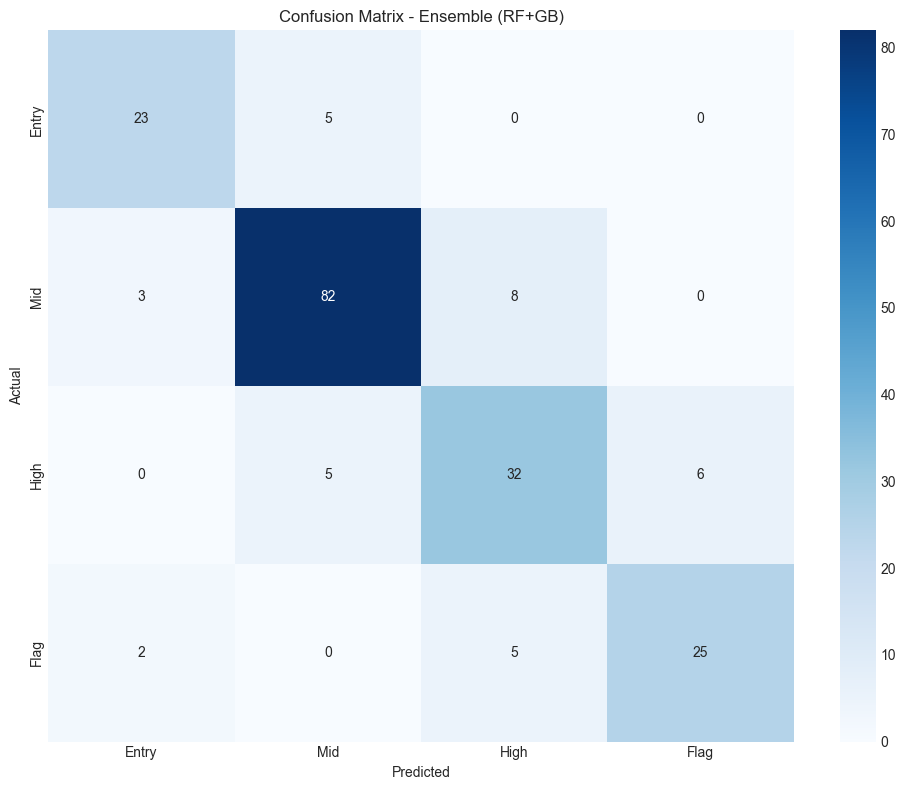

In [16]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
y_pred = price_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Entry', 'Mid', 'High', 'Flag'],
            yticklabels=['Entry', 'Mid', 'High', 'Flag'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_name}')
plt.tight_layout()
plt.show()

In [17]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                           target_names=['Entry Level', 'Mid Range', 'High End', 'Flagship']))


Classification Report:
              precision    recall  f1-score   support

 Entry Level       0.82      0.82      0.82        28
   Mid Range       0.89      0.88      0.89        93
    High End       0.71      0.74      0.73        43
    Flagship       0.81      0.78      0.79        32

    accuracy                           0.83       196
   macro avg       0.81      0.81      0.81       196
weighted avg       0.83      0.83      0.83       196



## 6. Train Usage Type Model

In [18]:
# Encode usage
usage_encoder = LabelEncoder()
y_usage = usage_encoder.fit_transform(df_clean['usage_type'])

# Split
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
    X, y_usage, test_size=0.2, random_state=42, stratify=y_usage
)

X_train_u_scaled = scaler.transform(X_train_u)
X_test_u_scaled = scaler.transform(X_test_u)

print(f"Usage model: {X_train_u.shape[0]} train, {X_test_u.shape[0]} test")

Usage model: 784 train, 196 test


In [19]:
# Train Usage models
rf_usage = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

gb_usage = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

# Ensemble
ensemble_usage = VotingClassifier(
    estimators=[('rf', rf_usage), ('gb', gb_usage)],
    voting='soft'
)

print("Training Usage models...")
rf_usage.fit(X_train_u_scaled, y_train_u)
gb_usage.fit(X_train_u_scaled, y_train_u)
ensemble_usage.fit(X_train_u_scaled, y_train_u)
print("✅ Done!")

Training Usage models...
✅ Done!


In [20]:
# Compare Usage models
usage_models = {
    'Random Forest': rf_usage,
    'Gradient Boosting': gb_usage,
    'Ensemble': ensemble_usage
}

print("="*70)
print("MODEL COMPARISON - USAGE TYPE")
print("="*70)

best_usage_acc = 0
best_usage_model = None

for name, model in usage_models.items():
    train_acc = accuracy_score(y_train_u, model.predict(X_train_u_scaled))
    test_acc = accuracy_score(y_test_u, model.predict(X_test_u_scaled))
    diff = train_acc - test_acc
    
    print(f"\n{name}:")
    print(f"  Train: {train_acc:.2%}")
    print(f"  Test:  {test_acc:.2%}")
    print(f"  Diff:  {diff:.2%}")
    
    if test_acc > best_usage_acc:
        best_usage_acc = test_acc
        best_usage_model = model
        best_usage_name = name

print(f"\n🏆 Best Usage Model: {best_usage_name}")
print(f"   Test Accuracy: {best_usage_acc:.2%}")

usage_model = best_usage_model

MODEL COMPARISON - USAGE TYPE

Random Forest:
  Train: 90.18%
  Test:  80.61%
  Diff:  9.57%

Gradient Boosting:
  Train: 99.11%
  Test:  80.61%
  Diff:  18.49%

Ensemble:
  Train: 98.09%
  Test:  83.16%
  Diff:  14.92%

🏆 Best Usage Model: Ensemble
   Test Accuracy: 83.16%


## 7. Learning Curves

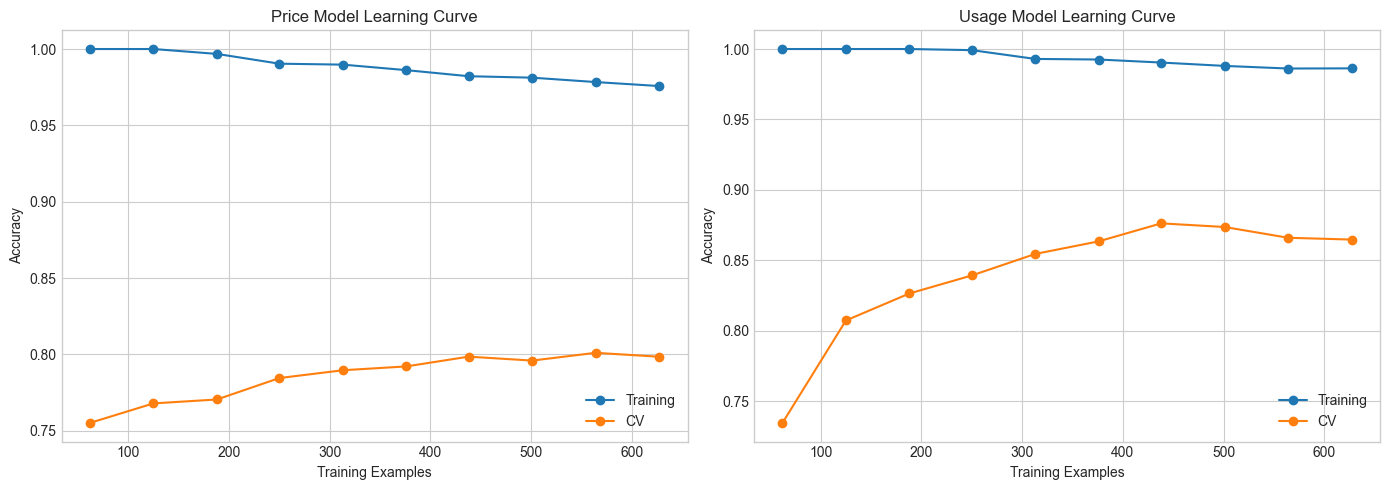


Final Gaps:
  Price Model: 17.73%
  Usage Model: 12.15%


In [21]:
# Learning curves untuk cek overfitting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price model
train_sizes, train_scores, test_scores = learning_curve(
    price_model, X_train_scaled, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

axes[0].plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training')
axes[0].plot(train_sizes, test_scores.mean(axis=1), 'o-', label='CV')
axes[0].set_xlabel('Training Examples')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Price Model Learning Curve')
axes[0].legend()
axes[0].grid(True)

# Usage model
train_sizes2, train_scores2, test_scores2 = learning_curve(
    usage_model, X_train_u_scaled, y_train_u, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

axes[1].plot(train_sizes2, train_scores2.mean(axis=1), 'o-', label='Training')
axes[1].plot(train_sizes2, test_scores2.mean(axis=1), 'o-', label='CV')
axes[1].set_xlabel('Training Examples')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Usage Model Learning Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Check gaps
gap1 = train_scores.mean(axis=1)[-1] - test_scores.mean(axis=1)[-1]
gap2 = train_scores2.mean(axis=1)[-1] - test_scores2.mean(axis=1)[-1]
print(f"\nFinal Gaps:")
print(f"  Price Model: {gap1:.2%}")
print(f"  Usage Model: {gap2:.2%}")

## 8. Save Models

In [22]:
# Save
model_dir = '../model'
os.makedirs(model_dir, exist_ok=True)

# Untuk Streamlit, gunakan RF karena lebih cepat untuk predict
# dan VotingClassifier tidak selalu compatible dengan semua versi
joblib.dump(rf_model, f'{model_dir}/smartphone_price_model.pkl')
joblib.dump(rf_usage, f'{model_dir}/smartphone_usage_model.pkl')
joblib.dump(scaler, f'{model_dir}/scaler.pkl')
joblib.dump(selected_features, f'{model_dir}/features.pkl')
joblib.dump(usage_encoder, f'{model_dir}/usage_encoder.pkl')
joblib.dump(price_class_names, f'{model_dir}/price_class_names.pkl')

print("\n✅ Models saved!")
for f in os.listdir(model_dir):
    if f.endswith('.pkl'):
        print(f"  - {f}")


✅ Models saved!
  - features.pkl
  - price_class_names.pkl
  - scaler.pkl
  - smartphone_price_model.pkl
  - smartphone_usage_model.pkl
  - usage_encoder.pkl


## 9. Test Predictions

In [23]:
def predict(specs):
    input_df = pd.DataFrame([specs], columns=selected_features)
    input_scaled = scaler.transform(input_df)
    
    price_pred = rf_model.predict(input_scaled)[0]
    price_proba = rf_model.predict_proba(input_scaled)[0]
    
    usage_pred = rf_usage.predict(input_scaled)[0]
    usage_proba = rf_usage.predict_proba(input_scaled)[0]
    
    return {
        'price_class': price_class_names[price_pred],
        'price_conf': price_proba[price_pred] * 100,
        'usage_type': usage_encoder.classes_[usage_pred],
        'usage_conf': usage_proba[usage_pred] * 100
    }

# Test Flagship
flagship = dict(zip(selected_features, [0]*len(selected_features)))
flagship.update({
    'ram_capacity': 12, 'internal_memory': 256, 'primary_camera_rear': 108,
    'refresh_rate': 120, 'processor_speed': 3.2, 'has_5g': 1,
    'perf_score': 12*3.2*8, 'camera_total': 140
})

result = predict(flagship)
print("Test: Flagship Gaming Phone")
print(f"  Price: {result['price_class']} ({result['price_conf']:.1f}%)")
print(f"  Usage: {result['usage_type']} ({result['usage_conf']:.1f}%)")

Test: Flagship Gaming Phone
  Price: Mid Range (32.7%)
  Usage: Gaming (64.9%)


## Final Summary

In [24]:
# Final results
price_train = accuracy_score(y_train, rf_model.predict(X_train_scaled))
price_test = accuracy_score(y_test, rf_model.predict(X_test_scaled))
usage_train = accuracy_score(y_train_u, rf_usage.predict(X_train_u_scaled))
usage_test = accuracy_score(y_test_u, rf_usage.predict(X_test_u_scaled))

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"\n📈 Price Class Model:")
print(f"   Train Accuracy: {price_train:.2%}")
print(f"   Test Accuracy:  {price_test:.2%}")
print(f"   Difference:     {price_train-price_test:.2%}")
print(f"   CV Score:       {cv_scores.mean():.2%}")

print(f"\n🎯 Usage Type Model:")
print(f"   Train Accuracy: {usage_train:.2%}")
print(f"   Test Accuracy:  {usage_test:.2%}")
print(f"   Difference:     {usage_train-usage_test:.2%}")

# Check target
if price_test >= 0.85:
    print(f"\n✅ Price Model: TARGET ACHIEVED (>85%)")
else:
    print(f"\n⬆️ Price Model: {price_test:.2%} (target: 85%)")
    
if usage_test >= 0.85:
    print(f"✅ Usage Model: TARGET ACHIEVED (>85%)")
else:
    print(f"⬆️ Usage Model: {usage_test:.2%} (target: 85%)")

print("\n📁 Models saved to: ../model/")
print("\n🚀 Run Streamlit: cd ../view && streamlit run app.py")


FINAL RESULTS

📈 Price Class Model:
   Train Accuracy: 85.84%
   Test Accuracy:  80.61%
   Difference:     5.23%
   CV Score:       81.23%

🎯 Usage Type Model:
   Train Accuracy: 90.18%
   Test Accuracy:  80.61%
   Difference:     9.57%

⬆️ Price Model: 80.61% (target: 85%)
⬆️ Usage Model: 80.61% (target: 85%)

📁 Models saved to: ../model/

🚀 Run Streamlit: cd ../view && streamlit run app.py
